# Classification and Clustering

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import collections, re, string, glob, collections, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from scipy.sparse import hstack
import imblearn

import utils_vectoriser

In [ ]:
## TO DO

# 2. back to Lab 2, extract author abstract NERs (are we getting NER spans or just token by token?) - yes we are 
# 3. imbalearn upsampling 
# 1. NMF to reduce dimensions with a resulting non-negative matrix, so we can accept the current form of 
# concreteness score into the classifiers 
# 4. lemma subset by POS tags 
# 5. tuning TFIDF levels 
# 2. LogReg


### Initial results
|Run   	|Classifier   	|Featureset   	|train acc   	|test acc   	|alpha   	|
|---	|---	|---	|---	|---	|---	|
|1   	|M_NB   	|subj, lemmas, parse_VP, book_nes    	|0.984   	|0.46   	|29   	|
|2   	|M_NB   	|   	|   	|   	|   	|
|   	|   	|   	|   	|   	|   	|
|   	|   	|   	|   	|   	|   	|

### 1. Create training and evaluation sets

#### 1a. Corollary: Computing a subjectivity score

We have access to a set of [subjectivity classification for about 8,200 English words](https://gitlab.inria.fr/mastertal/UE803/blob/master/data/l10_data/subjectivity_clues_hltemnlp05/subjclueslen1-HLTEMNLP05.README). We hypothesize that an average subjectivity score can help to further distinguish between authors. 
Our datapoints are however single sentences from at least 3 books of an author, and it is not sensible to compute the score for every sentence as there can be significant variability for such a score between an author's ouevre. Instead we compute the score based on the entire set of the author's sentences admitted into our corpus. 

We hypothesize that ideally, it will be better to compute the score based on each set of sentences from a single book of one author. This could provide a better predictor of an author's identity, by capturing a certain understanding about the subjecvity, and variability of the subjectivity, of his/her body of work. 

In [3]:
with open("../2_Preprocessing/supportdata/SubjectivityClues/data_l10_data_subjectivity_clues_hltemnlp05_subjclueslen1-HLTEMNLP05.tff", 
          "r") as file:
    subjectivityclues_all = file.read()
    
subj_scores = [1 if i == "type=weaksubj" else 2 for i in re.findall(r"type=[a-z]+", subjectivityclues_all)]
# encoding 1 and 2, since the classes are ordinal - "weaksubj" and "strongsubj"
subj_words = [i.lstrip("word1=") for i in re.findall(r"word1=[a-z]+", subjectivityclues_all)]
subj_pos = [i.lstrip("pos1=") for i in re.findall(r"pos1=[a-z]+", subjectivityclues_all)]
# side note on pos and stemming: the dataset does not use the UD POS tags, so we cannot map the tokens more precisely
# based on the POS tag we have for the corpus tokens. also, the Wilson et al 2005 data include whether the words were 
# stemmed (i.e. usable on our lemmas sets), but it numbers only 1620, out of 8222 words, or less than 20%. so we 
# should compute our subjectivity score using our tokens set instead of lemmas

subj_trip_info = [i for i in zip(subj_scores, subj_pos)]
__dictcombined = {subj_words[index]: subj_trip_info[index] for index in range(len(subj_words))}
# there are 5 words that have zero length and it is throwing an error in the filtering.
# also pointless to have a score for an empty string in the computation of the subjectivity score. 
# it might have come about at the re.findall level, but the empty word issue still persists
# after adding A-Z and 1-9 to the search pattern. 
__dictcombined_filter = {i: __dictcombined[i] for i in __dictcombined if len(i) > 0}

# sort into a dictionary to speed search time 
subj_dict = {}
for letter in string.ascii_lowercase: 
    subj_dict[letter] = {key:__dictcombined_filter[key] for key in __dictcombined_filter if key[0] == letter}
    

In [4]:
def get_subjectivity(spacysentdoc, subj_dict):
    '''given a spacysentdoc, or a np array of strings (tokens of a sentence), returns the subjectivity
    score for the sentence. The score is the sum of the score for tokens that can be 
    found in the http://crr.ugent.be/archives/1330 dataset. 
    Inputs: spacysentdoc
    Outputs: a tuple containing the function name and the result. result is an integer rounded to 3 dp 
    and converted to a string
    ''' 
    if type(spacysentdoc) == np.ndarray: 
        s_score = 0
        for sentence in spacysentdoc: 
            for token in sentence:
                try:
                    # using first letter of token, go to sub-dict of subj_dict
                    # if the token is one of the values of the sub-dict
                    # retrive the subjectivity score
                    if token in subj_dict[token[0]].keys():
                        s_score += int(subj_dict[token[0]][token][0])
                except: 
                    pass
        # the score is averaged across the number of tokens across the entire corpus/doc
        # it gives an indication of the usage of subjectivity words in writing style
        return "subjectivity", round(s_score/len(spacysentdoc), 3)
    else: 
        # condition for code extension to cover spacysentdoc (for alignment to insert into utils_tokeniser.py)
        pass
    

#### 1b. Importing pickled DFs, train-test split

__General approach__

1. iteratively load author pickled dfs, filter out sentences that are less than 10 tokens long (between the 25th and 50th percentile for sentence length across the entire corpus of all authors)
    - (since our dataset is built on one sentence per author, we drop sentences to avoid the possibility of an extremely sparse matrix. the short sentences would provide limited linguistics indicators (expressed through word freqency counts, ) to distinguish between authors. 
    - add author wiki abstract NERs
2. cut into train test split on each load (to ensure each author is evenly represented in the train and test sets)
3. concat train at end, concat test at end
4. fit tfidf on train (so as not to leak data into test), transform on train and test
5. cut into sets of features
6. export to svm light 

In [274]:
test_df= pd.read_pickle(glob.glob("../2_Preprocessing/processeddata/df_pickles/*.pickle")[0])
test_df.head(2)
authabs_ne_df["a7519"]

,authornum,concreteness,lemmas,ne_dates,ne_persons,ne_places,parse_NP,parse_S,parse_VP,pos_ADJ,...,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_SYM,pos_VERB,pos_X,poswordpairs,sentences,tokens,sent_length
0,a7519,-1.1,"[when, -PRON-, father, find, fault, because, -...",[],[],[],12,6,7,5,...,3,0,0,0,9,0,"[(ADV, When), (ADJ, her), (NOUN, father), (VER...",When her father found fault because she would ...,"[when, her, father, found, fault, because, she...",34
1,a7519,0.31,"[as, -PRON-, carefully, study, every, word, ,,...",[],[],[],16,4,6,1,...,5,0,0,0,5,0,"[(ADP, As), (PRON, I), (ADV, carefully), (VERB...","As I carefully study every word, I have heard ...","[as, i, carefully, study, every, word, i, have...",32


In [290]:
pd.concat([test_df, authabs_ne_df.loc["a7519"]], axis=0).columns

Index([   'authornum', 'concreteness',       'lemmas',     'ne_dates',
         'ne_persons',    'ne_places',     'parse_NP',      'parse_S',
           'parse_VP',      'pos_ADJ',      'pos_ADP',      'pos_ADV',
            'pos_AUX',    'pos_CCONJ',     'pos_CONJ',      'pos_DET',
           'pos_INTJ',     'pos_NOUN',      'pos_NUM',     'pos_PART',
           'pos_PRON',    'pos_PROPN',    'pos_PUNCT',    'pos_SCONJ',
          'pos_SPACE',      'pos_SYM',     'pos_VERB',        'pos_X',
       'poswordpairs',    'sentences',       'tokens',  'sent_length',
                    0],
      dtype='object')

In [151]:
# 0. grab all the pickled df files
df_filenames = glob.glob("../2_Preprocessing/processeddata/df_pickles/*.pickle")


# 1a. lists for collecting all the df objects to be generated for pd.concat - speediest approach 
# https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/24913075#24913075
dfs_list_train = [] 
dfs_list_test = []
label2auth_map = {}
auth2label_map = {}

# 1b. load the author wiki abstract NE data
authabs_ne_df_filenames = glob.glob("../2_Preprocessing/processeddata/df_pickle_abstracts/*.pickle")
authabs_ne_df  = pd.read_pickle(authabs_ne_df_filenames[0])

# 2. generate the master DF
label_counter = 1
for filename in df_filenames: 
    __ = pd.read_pickle(filename)
     
    authornum = __["authornum"][0]                             # get the authornum for this df
    pd.concat(__authabs_ne_df[authornum]                                   # add the author abstract wiki NEs to each row
    
                                
    label2auth_map[label_counter] = authornum                  # switch the authornum to int, store the mapping
    auth2label_map[authornum] = label_counter
    __["authornum"] = label_counter
    
    authabs_ne_df[authornum]
    
    __ = __[__["sent_length"]>10]                               # filter out short sentences
    __["concreteness"] = __["concreteness"].astype(float)       # we set the concreteness score as a string 
                                                                # to run the process_one_author functions easily
                                                                # switch back to int here
    # get the subjectivity score for the author. 
    s_score = get_subjectivity(__["tokens"].values,subj_dict)[1]
    # add as a new column to this df
    __["subjectivity"]=s_score
    

    # train test split 
    __train, __test = train_test_split(__, test_size=0.20)
    dfs_list_train.append(__train)
    dfs_list_test.append(__test)
    
    label_counter += 1
    
allauthor_df_train = pd.concat(dfs_list_train, axis=0)
allauthor_df_test = pd.concat(dfs_list_test, axis=0)
allauthor_df_train.reset_index(drop= True, inplace=True)
allauthor_df_test.reset_index(drop= True, inplace=True)

print("train size: {}, test size: {}".format(allauthor_df_train.shape,allauthor_df_test.shape))

train size: (13837, 33), test size: (3518, 33)


In [88]:
allauthor_df_test.describe()

,concreteness,parse_NP,parse_S,parse_VP,pos_ADJ,pos_ADP,pos_ADV,pos_AUX,pos_CCONJ,pos_CONJ,...,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_SYM,pos_VERB,pos_X,sent_length,subjectivity
count,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.0,3518.000000,3518.0,...,3518.000000,3518.000000,3518.000000,3518.0,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000
mean,-0.233903,9.529278,3.611427,5.413303,2.892268,3.704946,1.839682,0.0,1.165435,0.0,...,1.860148,1.167140,3.991757,0.0,0.348778,0.003127,4.964753,0.008812,26.817794,5.833819
std,6.069843,6.919672,2.567365,3.891442,2.718327,3.090785,1.847589,0.0,1.333469,0.0,...,1.820584,1.989003,2.956454,0.0,1.177827,0.084253,3.390416,0.124742,17.152813,1.710686
min,-52.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,11.000000,2.491000
25%,-3.400000,5.000000,2.000000,3.000000,1.000000,2.000000,1.000000,0.0,0.000000,0.0,...,1.000000,0.000000,2.000000,0.0,0.000000,0.000000,3.000000,0.000000,15.000000,4.379000
50%,0.015000,8.000000,3.000000,5.000000,2.000000,3.000000,1.000000,0.0,1.000000,0.0,...,1.000000,0.000000,3.000000,0.0,0.000000,0.000000,4.000000,0.000000,22.000000,5.764000
75%,3.460000,12.000000,5.000000,7.000000,4.000000,5.000000,3.000000,0.0,2.000000,0.0,...,3.000000,2.000000,5.000000,0.0,0.000000,0.000000,6.000000,0.000000,33.000000,6.790000
max,37.430000,132.000000,28.000000,65.000000,39.000000,35.000000,19.000000,0.0,12.000000,0.0,...,23.000000,34.000000,31.000000,0.0,13.000000,4.000000,39.000000,4.000000,226.000000,11.402000


In [89]:
allauthor_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 33 columns):
authornum       3518 non-null object
concreteness    3518 non-null float64
lemmas          3518 non-null object
ne_dates        3518 non-null object
ne_persons      3518 non-null object
ne_places       3518 non-null object
parse_NP        3518 non-null int64
parse_S         3518 non-null int64
parse_VP        3518 non-null int64
pos_ADJ         3518 non-null int64
pos_ADP         3518 non-null int64
pos_ADV         3518 non-null int64
pos_AUX         3518 non-null int64
pos_CCONJ       3518 non-null int64
pos_CONJ        3518 non-null int64
pos_DET         3518 non-null int64
pos_INTJ        3518 non-null int64
pos_NOUN        3518 non-null int64
pos_NUM         3518 non-null int64
pos_PART        3518 non-null int64
pos_PRON        3518 non-null int64
pos_PROPN       3518 non-null int64
pos_PUNCT       3518 non-null int64
pos_SCONJ       3518 non-null int64
pos_SPACE       3518 n

#### 1c. Exploring the dataset

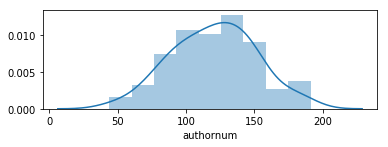

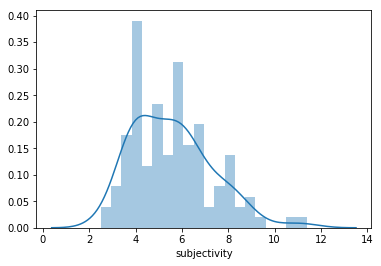

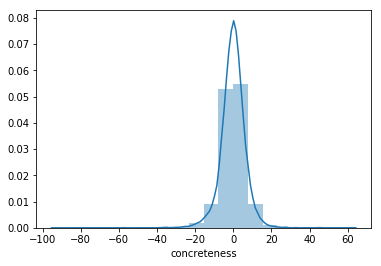

In [93]:
plt.subplot(2, 1, 2)
# let's take a look at the population distribution, to see if we need to finetune the corpus or augment datapoints
sns.distplot(allauthor_df_train.groupby("authornum")["authornum"].count())
plt.show()
# distribution of mean subjectivity score for each author's sentences  
sns.distplot(allauthor_df_train.groupby(["authornum","subjectivity"])["subjectivity"].mean(), bins=20)
plt.show()
# distribution of mean concreteness score for each author's sentences  
sns.distplot(allauthor_df_train.groupby(["authornum","concreteness"])["concreteness"].mean(), bins=20)
plt.show()

#### 1d. Vectorising lemmas and NERs

Our custom vectoriser in utils_vectoriser is not appropriate for this task. 
We tokenise lemmas to minimise sparsity

In [192]:
allauthor_df_test.shape

(3518, 33)

In [200]:
__features = {"lemmas": 
                  {"train": allauthor_df_train["lemmas"],
                    "test": allauthor_df_test["lemmas"],},
              "namedentities": 
                  {"train": allauthor_df_train['ne_dates']+allauthor_df_train['ne_places'],
                   "test": allauthor_df_test['ne_dates']+allauthor_df_test['ne_places'],}, }
                # add the ne_dates and ne_places columns for the vectoriser to manage sparsity. leave out 
                # persons for now, it is possible person names can significantly identify authors (except 
                # perhaps authors) 
                          
for feat in __features:
    # train data
    token_Counters_train = []
    for row in __features[feat]["train"].index:
        token_Counters_train.append(collections.Counter(__features[feat]["train"][row]))
    
    # test data 
    token_Counters_test = []
    for row in __features[feat]["test"].index:
        token_Counters_test.append(collections.Counter(__features[feat]["test"][row]))
    
    Dvectoriser = DictVectorizer()
    Dvect_result_train = Dvectoriser.fit_transform(token_Counters_train)
    Dvect_result_test = Dvectoriser.transform(token_Counters_test)

    Ttransformer = TfidfTransformer()
    Ttrans_results_train = Ttransformer.fit_transform(Dvect_result_train)
    Ttrans_results_test = Ttransformer.transform(Dvect_result_test)

    dump_svmlight_file(Ttrans_results_train, allauthor_df_train["authornum"], "data/train_"+feat+".svmlight")
    dump_svmlight_file(Ttrans_results_test, allauthor_df_test["authornum"], "data/test_"+feat+".svmlight")

In [209]:
__other_features=['concreteness', 'subjectivity', "parse_VP"]
for feat in __other_features:
    dump_svmlight_file(allauthor_df_train[feat].values.reshape(-1,1),
                       allauthor_df_train["authornum"], "data/train_"+feat+".svmlight")
    dump_svmlight_file(allauthor_df_test[feat].values.reshape(-1,1), 
                       allauthor_df_test["authornum"], "data/test_"+feat+".svmlight")        

In [207]:
allauthor_df_train.columns

Index(['authornum', 'concreteness', 'lemmas', 'ne_dates', 'ne_persons',
       'ne_places', 'parse_NP', 'parse_S', 'parse_VP', 'pos_ADJ', 'pos_ADP',
       'pos_ADV', 'pos_AUX', 'pos_CCONJ', 'pos_CONJ', 'pos_DET', 'pos_INTJ',
       'pos_NOUN', 'pos_NUM', 'pos_PART', 'pos_PRON', 'pos_PROPN', 'pos_PUNCT',
       'pos_SCONJ', 'pos_SPACE', 'pos_SYM', 'pos_VERB', 'pos_X',
       'poswordpairs', 'sentences', 'tokens', 'sent_length', 'subjectivity'],
      dtype='object')

### 2. Large multiclass classification 

In [251]:
def load_data(data_path = "./data", features='lemmas'):
    
    X_train, y_train = load_svmlight_file( data_path+'/train_'+features+".svmlight" ) 
    X_test, y_test = load_svmlight_file( data_path+'/test_'+features+".svmlight", n_features=X_train.shape[1] ) 
    # shape of test shouldn't matter here since we enforced it at the vectorising step above
    
    return X_train, y_train, X_test, y_test

# Testing lemmas
X_train, y_train, X_test, y_test = load_data( "./data", features='lemmas')
print( "Train:", X_train.shape )
print( "Test:", X_test.shape )


Train: (13837, 24854)
Test: (3518, 24854)


In [248]:
def train_clf( X, y, classifier='nb', alpha=1.0 ):
    if classifier== 'nb':
        classifier = MultinomialNB(alpha=alpha, fit_prior=True, class_prior=None) 
        # Train 
        classifier.fit( X, y )
    return classifier

def evaluate( classifier, X, y ):
    # Predict
    y_pred = classifier.predict( X )
    return y_pred 

def compute_acc(y_true, y_pred):
    return metrics.accuracy_score( y_true, y_pred )

def tune_nb( X_train, y_train, X_test, y_test ):
    train_acc,test_acc,alphas = [],[],[]
    for alpha in np.linspace(0,1,11):
        alpha = round(alpha, 1)
        alphas.append(alpha)
        clf = train_clf( X_train, y_train, classifier='nb', alpha=alpha )
        #print(clf)
        y_pred_train = evaluate( clf, X_train, y_train )
        tr_acc = compute_acc(y_train, y_pred_train)
        train_acc.append( tr_acc )
    
        y_pred_test = evaluate( clf, X_test, y_test )
        d_acc = compute_acc(y_test, y_pred_test)
        test_acc.append( d_acc )
        print( alpha, round( tr_acc*100, 3), round( d_acc*100, 3) )
    return train_acc, test_acc, alphas

def plot_tune_nb( train_acc, test_acc, alphas):    
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.2,0.8,0.9] )
    ax.plot( alphas, train_acc, 'blue', label='train' )
    ax.plot( alphas, test_acc, 'red', label='test' )
    ax.legend()
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Accuracy')

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.0 98.8 29.022
0.1 89.846 29.79
0.2 80.429 26.89
0.3 71.901 24.503
0.4 64.653 22.712
0.5 58.849 21.319
0.6 54.058 20.381
0.7 50.206 19.301
0.8 46.751 18.334
0.9 44.092 17.482
1.0 41.461 16.885


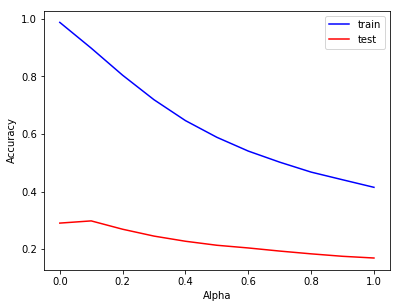

In [249]:
train_acc_uni, test_acc_uni, alphas = tune_nb(X_train, y_train, X_test, y_test )
plot_tune_nb( train_acc_uni, test_acc_uni, alphas )

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.0 98.836 26.634
0.1 46.036 10.546
0.2 23.329 5.458
0.3 13.804 3.61
0.4 9.46 2.672
0.5 7.22 2.246
0.6 5.868 2.018
0.7 4.871 1.961
0.8 4.278 1.876
0.9 3.83 1.819
1.0 3.382 1.706


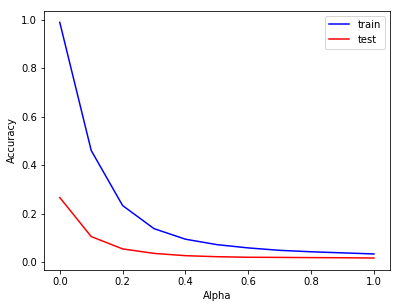

In [261]:
def stack( A, B ):
    return hstack( [A,B] )

X_tr_lemmas, y_train, X_te_lemmas, y_test = load_data( "./data", features='lemmas')
X_tr_concreteness, y_train, X_te_concreteness, y_test = load_data( "./data", features='concreteness')
X_tr_namedentities, y_train, X_te_namedentities, y_test = load_data( "./data", features='namedentities')
X_tr_parse_VP, y_train, X_te_parse_VP, y_test = load_data( "./data", features='parse_VP')
X_tr_subjectivity, y_train, X_te_subjectivity, y_test = load_data( "./data", features='subjectivity')



X_train = hstack( [X_tr_subjectivity, X_tr_lemmas,X_tr_namedentities, X_tr_parse_VP] )
X_test = hstack( [X_te_subjectivity, X_te_lemmas, X_te_namedentities, X_te_parse_VP] )

train_acc_uni, test_acc_uni, alphas = tune_nb(X_train, y_train, X_test, y_test )
plot_tune_nb( train_acc_uni, test_acc_uni, alphas )

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train)

In [ ]:
### --- SUPERCEDED --- ### we are doing multiclass and not multilabel

# we need to get the labels encoded like this for multilabel classification
# step 1, find out how many unique labels we have in the corpus
# have a look at the distribution of the label. are there significant outliers. if few, consider removing them
# else, we may consider augmenting datapoints with SMOTE 
X, Y = make_multilabel_classification(n_classes=5, n_labels=5,
                                      allow_unlabeled=True,
                                      random_state=1)
Y[0]

### 3. Clustering with Graph propagation extension

In [ ]:
# i think we can try this. since our data set is not very big. we could use our initial clusters as a feature and retrain 
# the classifier 

# https://arxiv.org/pdf/1709.05634.pdf 
# get books of the author that has not been admitted into the corpus. same min_books, max_books criteria (3,30) which 
# was is reasonably general enough - objective. 